# Combine spectroscopic properties, rotation periods and distances to get precise ages.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from astropy.io import fits
from astropy.table import Table
from isochrones.mist import MIST_Isochrone
from isochrones import StarModel
import emcee
import priors
import corner

Load the crossmatched data file with Gaia data, CKS spectroscopic properties and rotation periods.

In [2]:
df = pd.read_csv("kane_cks_tdmra_dr2.csv")
for i in df.keys():
    print(i)

Unnamed: 0
koi_id
planet_designation
p_orb_days
a_AU
r_pl_earth
teff_x
r_star_rsol
insolation_flux_F_E
KOI
id_starname
id_kic
id_koicand
id_kepler_name
koi_disposition
koi_period
koi_period_err1
koi_period_err2
koi_time0
koi_time0_err1
koi_time0_err2
koi_impact
koi_impact_err1
koi_impact_err2
koi_duration
koi_duration_err1
koi_duration_err2
koi_ingress
koi_ingress_err1
koi_ingress_err2
koi_depth
koi_depth_err1
koi_depth_err2
koi_ror
koi_ror_err1
koi_ror_err2
koi_srho
koi_srho_err1
koi_srho_err2
koi_prad
koi_prad_err1
koi_prad_err2
koi_sma
koi_sma_err1
koi_sma_err2
koi_teq
koi_teq_err1
koi_teq_err2
koi_insol
koi_insol_err1
koi_insol_err2
koi_dor
koi_dor_err1
koi_dor_err2
koi_max_mult_ev
koi_model_snr
koi_count
koi_num_transits
koi_steff
koi_steff_err1
koi_steff_err2
koi_slogg
koi_slogg_err1
koi_slogg_err2
koi_smet
koi_smet_err1
koi_smet_err2
koi_srad
koi_srad_err1
koi_srad_err2
koi_smass
koi_smass_err1
koi_smass_err2
koi_sage
koi_sage_err1
koi_sage_err2
koi_sparprov
kic_kepmag
kic_jmag


Calculate B-V colours for Gaia stars using their Bp-Rp colours.

In [3]:
def bv_2_bprp(bv):
    """
    Numbers from https://arxiv.org/pdf/1008.0815.pdf
    """
    a, b, c, d = .0981, 1.4290, -.0269, .0061  # sigma = .43
    return a + b*bv + c*bv**2 + d*bv**3

def bprp_2_bv(bprp):
    """
    Try to find the analytic version of this, please!
    """
    bv_iter = np.linspace(0., 2., 10000)
    bprp_pred = [bv_2_bprp(bv) for bv in bv_iter]
    diffs = bprp - np.array(bprp_pred)
    # plt.plot(bprp_pred, diffs**2)
    return bv_iter[np.argmin(diffs**2)]

bv_color = []
for i in range(np.shape(df)[0]):
    bv_color.append(bprp_2_bv(df.phot_bp_mean_mag.values[i] - df.phot_rp_mean_mag.values[i]))
df["BV_color"] = np.array(bv_color)

Combine isochrones.py with a gyro model to get ages.

In [4]:
# Set up the stuff needed by isochrones.py

mist = MIST_Isochrone()

i = 0  # Just run on the first star.

# Set the initial values
mass_init = df.iso_smass.values[i]
age_init = 2e9
feh_init = df.cks_smet.values[i]
distance_init = 1./df.parallax.values[i]
Av_init = .1

# sample in ln(mass), log10(age) and ln(distance).
p_init = np.array([np.log(mass_init), np.log10(age_init), feh_init, np.log(distance_init), Av_init])

# Set up the StarModel object needed to calculate the likelihood. 
param_dict = {"J": (df.jmag.values[i], df.jmag.values[i]*.05),
              "H": (df.hmag.values[i], df.hmag.values[i]*.05),
              "K": (df.kmag.values[i], df.kmag.values[i]*.05),
              "teff": (df.cks_steff.values[i], df.cks_steff_err1.values[i]),
              "logg": (df.cks_slogg.values[i], df.cks_slogg_err1.values[i]),
              "feh": (df.cks_smet.values[i], df.cks_smet_err1.values[i]),
              "parallax": (df.parallax.values[i],
                           (df.parallax_error.values[i]))}  # Isochrones.py takes milliarcseconds

mod = StarModel(mist, **param_dict)

Define the gyrochronology model. I'm using the Barnes (2003) functional form with my (2015) parameters.

In [5]:
def gyro_model(ln_age, bv):
    """
    Given a B-V colour and an age, predict a rotation period.
    Returns log(age) in Myr.
    parameters:
    ----------
    logage: (array)
        The log age of a star: log10(age) in years.
    bv: (array)
        The B-V colour of a star.
    """
    age_myr = (10**ln_age)*1e-6
    
    a, b, c, n = [.4, .31, .45, .55]
    
    # return a*(age_myr)**n * (bv - c)**b
    log_P = n*np.log10(age_myr) + np.log10(a) + b*np.log10(bv-c)
    return 10**log_P

Define the log prior and the log posterior functions.

In [75]:
def lnprior(params):
    """
    lnprior on all parameters.
    params need to be linear except age which is log10(age [yr]).
    """
    
    # log Priors over age, metallicity and distance. (The priors in priors.py are not in log)
    age_prior = np.log(priors.age_prior(params[1]))
    feh_prior = np.log(priors.feh_prior(params[2]))
    distance_prior = np.log(priors.distance_prior(np.exp(params[3])))

    # Uniform prior on extinction.
    mAv = (0 <= params[4]) * (params[4] < 1)  # Prior on A_v
    mAv = mAv == 1
    
    # Uniform prior on mass
    m = (-20 < params[0]) * (params[0]) < 20  # Broad bounds on mass.
    
    #print("age", params[0], age_prior)
    #print("mass", params[1], m)
    #print("feh", params[2], feh_prior)
    #print("distance", params[3], distance_prior)
    #print("extinction", params[4], mAv)
    
    if mAv and m and np.isfinite(age_prior) and np.isfinite(distance_prior):
        return age_prior + feh_prior + distance_prior
    
    else:
        return -np.inf

    
def lnprob_iso_only(lnparams, *args):
    """
    The log-probability if you don't want to include any rotation period information.
    """
    # Transform mass and distance back to linear.
    params = lnparams*1
    params[0] = np.exp(lnparams[0])
    params[3] = np.exp(lnparams[3])
    mod, period, period_err, bv = args    
    return mod.lnlike(params) + lnprior(lnparams)


def lnprob(lnparams, *args):
    # Transform mass and distance back to linear.
    params = lnparams*1
    params[0] = np.exp(lnparams[0])
    params[3] = np.exp(lnparams[3])
    
    mod, period, period_err, bv, gyro_only, iso_only = args
    
    if not iso_only:
        gyro_lnlike = -.5*((period - gyro_model(params[1], bv)) /period_err)**2
    
    if gyro_only:
        return gyro_lnlike + lnprior(lnparams)
    
    elif iso_only:
        return mod.lnlike(params) + lnprior(lnparams)
    
    else:
        return mod.lnlike(params) + gyro_lnlike + lnprior(lnparams)

Test the lnprob (you have to 'unstar' args above for this to work. Put it back for the next cell, though)

In [11]:
ndim, nwalkers = 5, 24
args = [mod, df.period.values[i], .5*(df.period_errm.values[i] + df.period_errp.values[i]),
        df.BV_color.values[i], gyro_only=False, iso_only=False]
print(lnprob(p_init, args))
print(lnprob(p_init + np.random.randn(ndim)*1e-4, args))

-1000582498.6502502
-1000173125.2960222


Run the MCMC.

In [13]:
p0 = [p_init + np.random.randn(ndim)*1e-4 for i in range(nwalkers)]

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=args)
p0, _, _ = sampler.run_mcmc(p0, 5000);
sampler.reset()
sampler.run_mcmc(p0, 10000);

/Users/ruthangus/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:8: RuntimeWarning: divide by zero encountered in log


Plot the results in linear space.

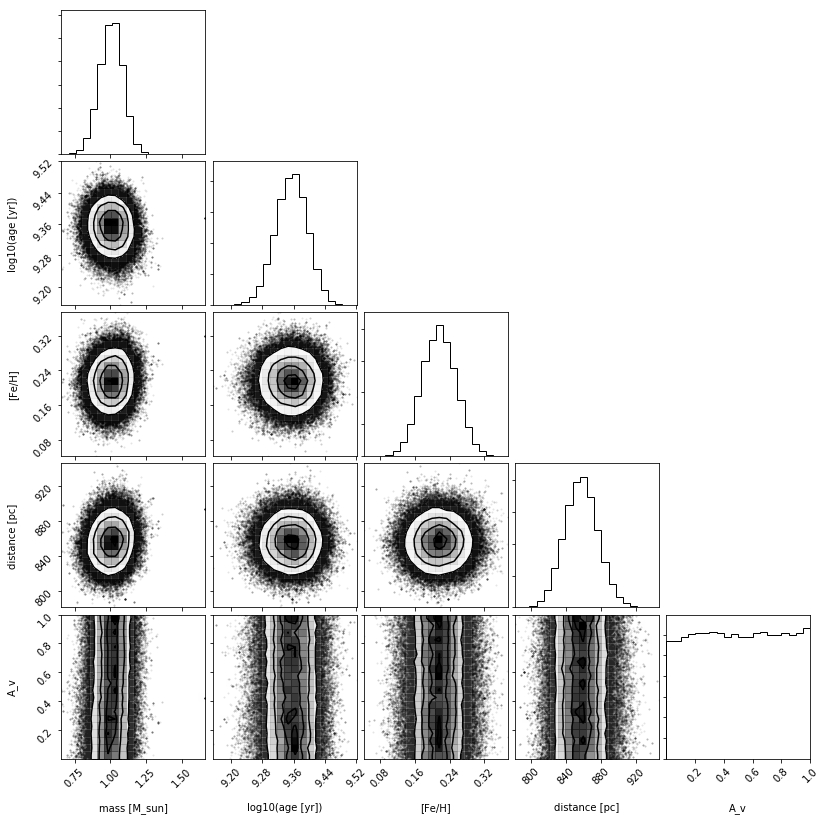

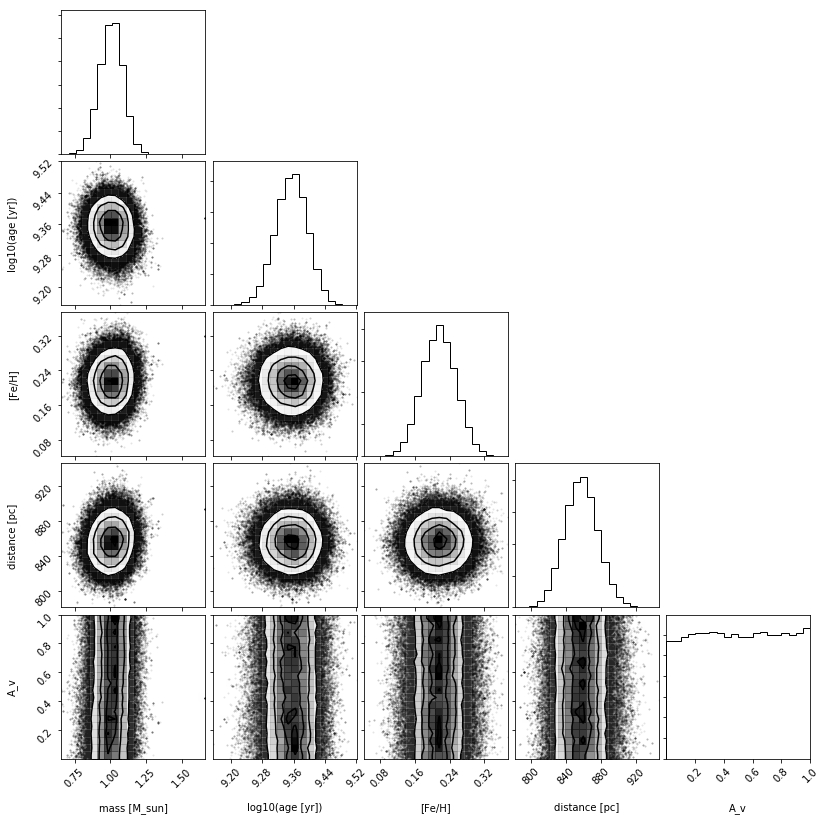

In [14]:
samples = sampler.flatchain
samples[:, 0] = np.exp(sampler.flatchain[:, 0])
samples[:, 3] = np.exp(sampler.flatchain[:, 3])

corner.corner(samples, labels=["mass [M_sun]", "log10(age [yr])", "[Fe/H]", "distance [pc]", "A_v"])

Plot the marginalised posterior over age.

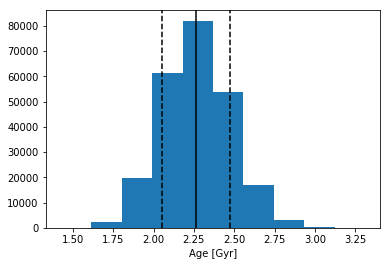

In [15]:
age_gyr = 10**samples[:, 1]*1e-9
plt.hist(age_gyr)
plt.xlabel("Age [Gyr]")
plt.axvline(np.median(age_gyr), color="k")
plt.axvline(np.median(age_gyr)-np.std(age_gyr), color="k", linestyle="--")
plt.axvline(np.median(age_gyr)+np.std(age_gyr), color="k", linestyle="--")

How much of this is coming from gyrochronology and how much from isochrones?
What's the rotation predicted by gyrochronology?

In [16]:
def gyro_model_age(period, bv):
    
    a, b, c, n = [.4, .31, .45, .55]
    log_A = (np.log10(period) - np.log10(a) - b*np.log10(bv-c))/n
    return 10**log_A

def gyro_model_period(age_myr, bv):
    a, b, c, n = [.4, .31, .45, .55]
    log_P = n*np.log10(age_myr) + np.log10(a) + b*np.log10(bv-c)
    return 10**log_P

In [17]:
print("predicted age = ", 10**np.median(samples[:, 1])*1e-9, "Gyr")
print("measured period = ", df.period.values[0], "days")
print("predicted period = ", gyro_model_period(10**np.median(samples[:, 1])*1e-6, df.BV_color.values[0]))

predicted age =  2.262359183478145 Gyr
measured period =  19.493700177100767 days
predicted period =  19.507577222262775


What happens if you just use an isochronal likelihood function?

In [19]:
# Test the lhf
args = [mod, df.period.values[i], .5*(df.period_errm.values[i] + df.period_errp.values[i]),
        df.BV_color.values[i]]
print(lnprob_iso_only(p_init, args))
print(lnprob_iso_only(p_init + np.random.randn(ndim)*1e-4, args))

-1000582497.8554822
-1000750930.1571578


/Users/ruthangus/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:8: RuntimeWarning: divide by zero encountered in log


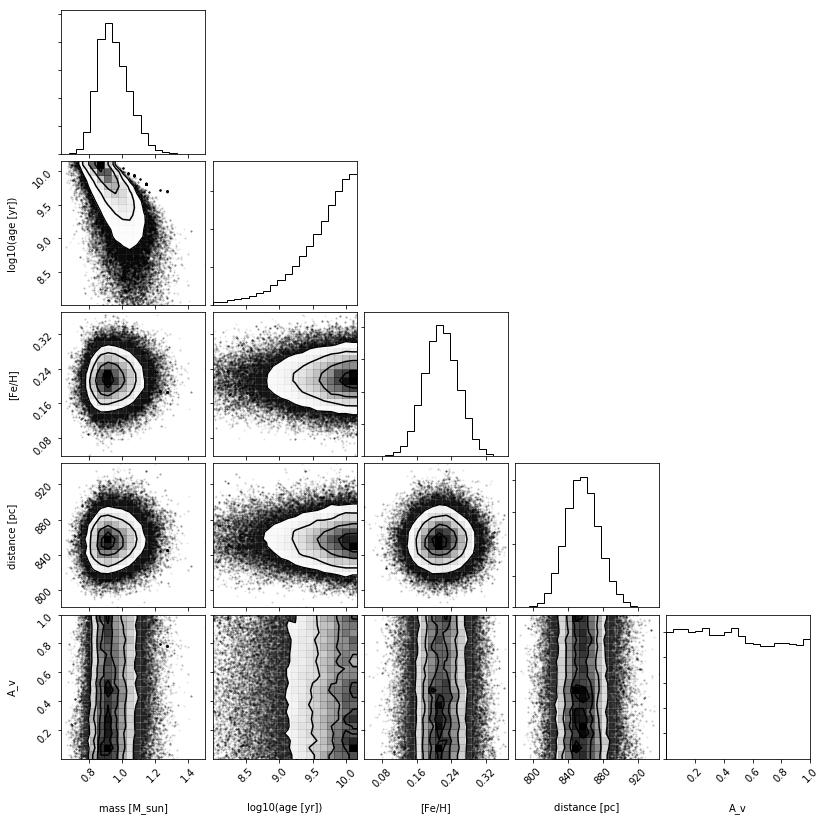

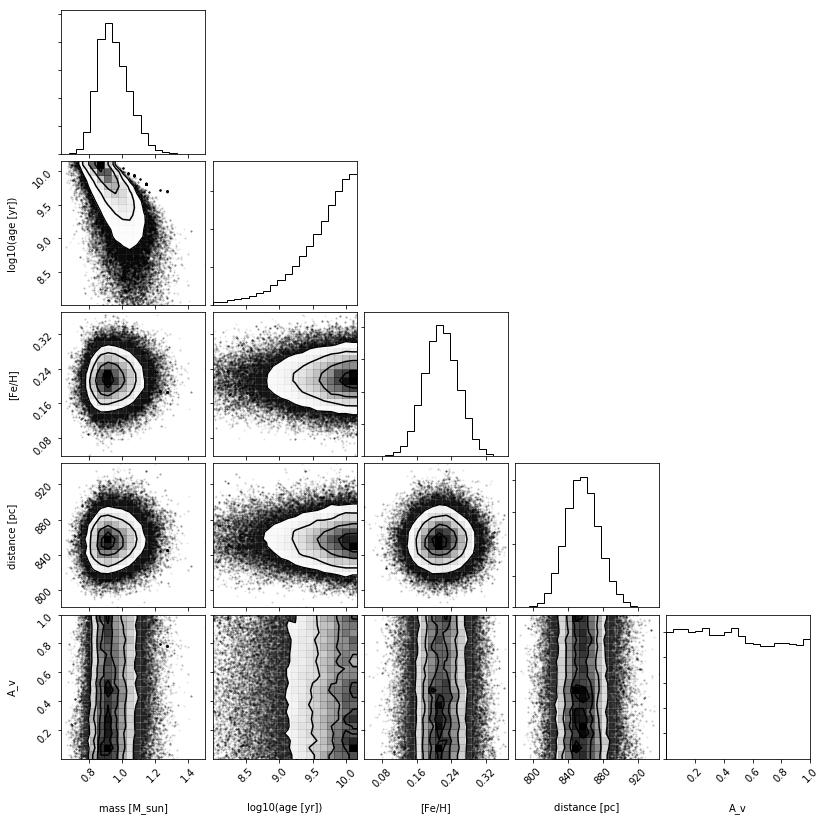

In [21]:
# Run MCMC
p0 = [p_init + np.random.randn(ndim)*1e-4 for i in range(nwalkers)]

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob_iso_only, args=args)
p0, _, _ = sampler.run_mcmc(p0, 5000);
sampler.reset()
sampler.run_mcmc(p0, 10000);

samples = sampler.flatchain
samples[:, 0] = np.exp(sampler.flatchain[:, 0])
samples[:, 3] = np.exp(sampler.flatchain[:, 3])

corner.corner(samples, labels=["mass [M_sun]", "log10(age [yr])", "[Fe/H]", "distance [pc]", "A_v"])

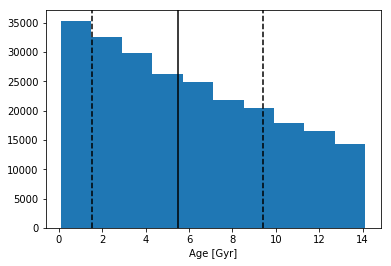

In [22]:
age_gyr = 10**samples[:, 1]*1e-9
plt.hist(age_gyr)
plt.xlabel("Age [Gyr]")
plt.axvline(np.median(age_gyr), color="k")
plt.axvline(np.median(age_gyr)-np.std(age_gyr), color="k", linestyle="--")
plt.axvline(np.median(age_gyr)+np.std(age_gyr), color="k", linestyle="--")

So you just recover the prior. What about just a rotation period lhf?

In [46]:
def lnprob_gyro_only(lnparams, *args):
    """
    The log-probability if you don't want to include any rotation period information.
    """
    # Transform mass and distance back to linear.
    params = lnparams*1
    params[0] = np.exp(lnparams[0])
    params[3] = np.exp(lnparams[3])
    mod, period, period_err, bv = args
    
    gyro_lnlike = -.5*((period - gyro_model(params[1], bv)) /period_err)**2
    #print(gyro_lnlike, lnprior(lnparams))
    return gyro_lnlike + lnprior(lnparams)

In [45]:
# Test the lhf
args = [mod, df.period.values[i], .5*(df.period_errm.values[i] + df.period_errp.values[i]),
        df.BV_color.values[i]]

#print(lnprob_gyro_only(p_init, args))
#print(lnprob_gyro_only(p_init + np.random.randn(ndim)*1e-4, args))
print(lnprob_gyro_only([-405.6215659, 10.23821157, -6.70719291, 360.53886680, 0.79342518], args))

-inf


/Users/ruthangus/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:8: RuntimeWarning: divide by zero encountered in log
/Users/ruthangus/projects/habitablezoning/priors.py:34: RuntimeWarning: overflow encountered in double_scalars
  return 3/max_distance**3 * distance**2


In [47]:
# Run MCMC
p0 = [p_init + np.random.randn(ndim)*1e-4 for i in range(nwalkers)]

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob_gyro_only, args=args)
p0, _, _ = sampler.run_mcmc(p0, 5000);
sampler.reset()
sampler.run_mcmc(p0, 10000);

samples = sampler.flatchain
samples[:, 0] = np.exp(sampler.flatchain[:, 0])
samples[:, 3] = np.exp(sampler.flatchain[:, 3])

#corner.corner(samples, labels=["mass [M_sun]", "log10(age [yr])", "[Fe/H]", "distance [pc]", "A_v"])

/Users/ruthangus/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:8: RuntimeWarning: divide by zero encountered in log
/Users/ruthangus/projects/habitablezoning/priors.py:34: RuntimeWarning: overflow encountered in double_scalars
  return 3/max_distance**3 * distance**2
/Users/ruthangus/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:7: RuntimeWarning: overflow encountered in exp


ValueError: It looks like the parameter(s) in column(s) 0 have no dynamic range. Please provide a `range` argument.

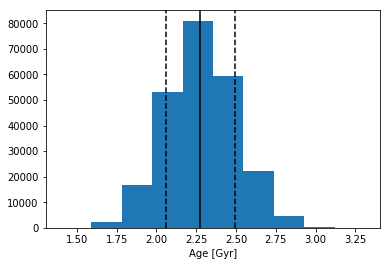

In [48]:
age_gyr = 10**samples[:, 1]*1e-9
plt.hist(age_gyr)
plt.xlabel("Age [Gyr]")
plt.axvline(np.median(age_gyr), color="k")
plt.axvline(np.median(age_gyr)-np.std(age_gyr), color="k", linestyle="--")
plt.axvline(np.median(age_gyr)+np.std(age_gyr), color="k", linestyle="--")

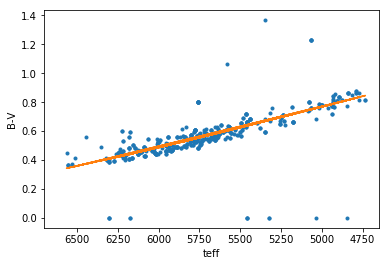

In [65]:
plt.plot(df.cks_steff.values, df.BV_color.values, ".")
plt.ylabel("B-V")
plt.xlabel("teff")
plt.xlim(6700, 4650)

coeffs = np.polyfit(df.cks_steff.values, df.BV_color.values, 3)
plt.plot(df.cks_steff.values, np.polyval(coeffs, df.cks_steff.values))

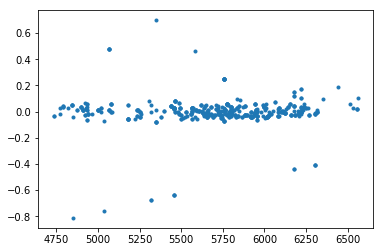

In [59]:
plt.plot(df.cks_steff.values, df.BV_color - np.polyval(coeffs, df.cks_steff.values), ".")

Test the relation I found in the literature.

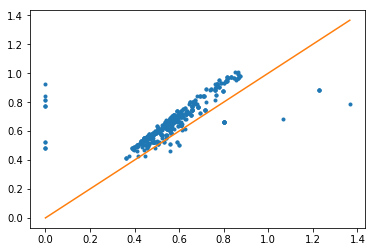

In [69]:
import teff_bv as tbv
plt.plot(df.BV_color.values, tbv.teff2bv(df.cks_steff.values, df.cks_slogg.values, df.cks_smet.values), ".")
xs = np.linspace(min(df.BV_color.values), max(df.BV_color.values))
plt.plot(xs, xs)

This actually does worse than just using 

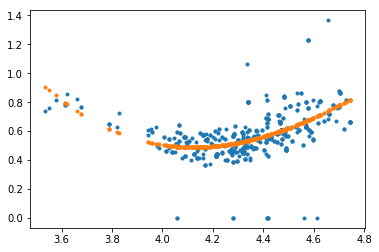

In [77]:
plt.plot(df.cks_slogg.values, df.BV_color.values, ".")
coeffs = np.polyfit(df.cks_slogg.values, df.BV_color.values, 3)
plt.plot(df.cks_slogg.values, np.polyval(coeffs, df.cks_slogg.values), ".")

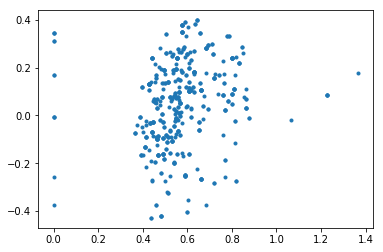

In [71]:
plt.plot(df.BV_color.values, df.cks_smet.values, ".")

No dependence on metallicity.

Do linear regression to derive a new formula for converting temperature and logg into mass.